<a href="https://colab.research.google.com/github/VinayChavan2006/EE655-Computer-Vision-and-Deep-Learning/blob/main/Assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import libraries
import numpy as np
import torch
from torchvision import datasets

# Load MNIST
mnist_train = datasets.MNIST(root='data', train=True, download=True)
mnist_test = datasets.MNIST(root='data', train=False, download=True)

images_train = mnist_train.data.numpy()  # Shape: (60000, 28, 28)
images_test = mnist_test.data.numpy()    # Shape: (10000, 28, 28)
labels_train = mnist_train.targets.numpy()
labels_test = mnist_test.targets.numpy()


In [4]:
import os
import cv2
import matplotlib.pyplot as plt
os.makedirs("./data/masks/train", exist_ok=True)
os.makedirs("./data/masks/test", exist_ok=True)

# Function to apply Otsu thresholding and create masks
def apply_otsu_threshold(image):
    # Apply Otsu thresholding
    _, mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return (mask/255).astype(np.uint8)

# Apply Otsu thresholding to each image and save masks
idx = 0
masks_train = []
masks_test = []
for image,label in zip(images_train,labels_train):
  # apply otsu algo
  res_image = (apply_otsu_threshold(image))
  masks_train.append(res_image * 255)
  cv2.imwrite(os.path.join("./data/masks/train/",f"{idx}.png"),res_image)
  idx += 1
idx = 0
for image,label in zip(images_test,labels_test):
  # apply otsu algo
  res_image = (apply_otsu_threshold(image))
  masks_test.append(res_image * 255)
  cv2.imwrite(os.path.join("./data/masks/test/",f"{idx}.png"),res_image)
  idx += 1

masks_train = np.array(masks_train,dtype=np.uint8)
masks_test = np.array(masks_test,dtype=np.uint8)

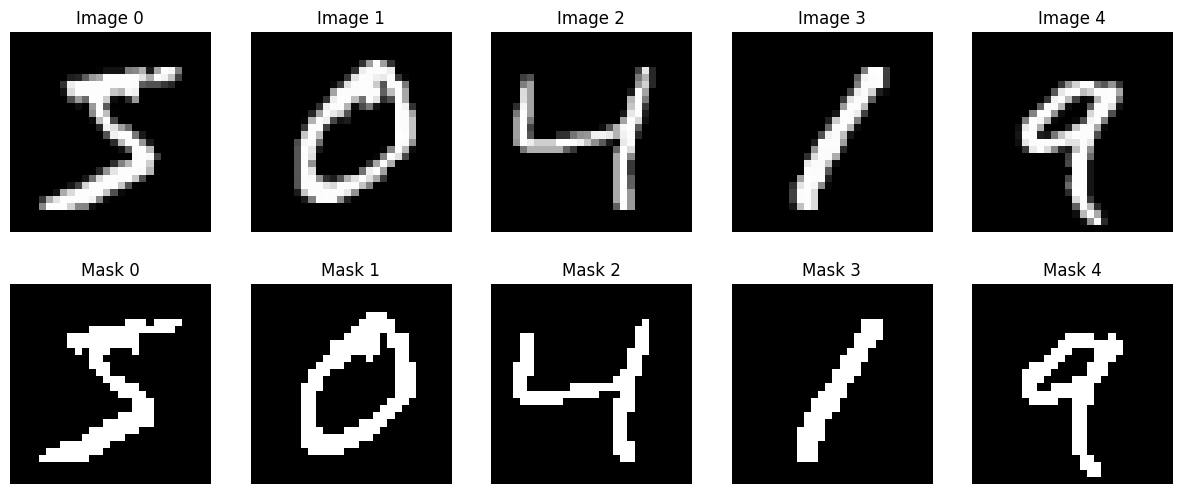

In [5]:
# print(masks_train)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.imshow(images_train[i], cmap='gray')
        ax.set_title(f"Image {i}")
    else:
        ax.imshow(masks_train[i-5], cmap='gray')
        ax.set_title(f"Mask {i-5}")
    ax.axis('off')
plt.show()

In [6]:
# Tight Ground Truth Circles
def get_tight_circles_images(img_mask):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
    # get all contours
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get the tight circle for each
    if len(contours) > 0:
        # Find the contour with the largest area
        largest_contour = max(contours, key=cv2.contourArea)
        # fit a circle
        (x,y),radius = cv2.minEnclosingCircle(largest_contour)
        # Convert the circle parameters to integers
        center = (int(x), int(y))
        radius = int(radius)
        # Draw a circle with these parameters
        cv2.circle(img_mask, center, radius, (0,255,0),2)
        return img_mask,center,radius
    else:
        return None,None,None
circle_train_images = []
circle_test_images = []
circle_train = []
circle_test = []
os.makedirs("./data/mnist_circles/train/",exist_ok=True)
os.makedirs("./data/mnist_circles/test/",exist_ok=True)

for i in range(len(images_train)):
    img = cv2.imread(f"./data/masks/train/{i}.png") * 255
    circ_img,center,radius = get_tight_circles_images(img)
    circle_train_images.append(circ_img)
    circle_train.append([center,radius])
    cv2.imwrite(f"./data/mnist_circles/train/{i}.png",circ_img)

for i in range(len(images_test)):
    img = cv2.imread(f"./data/masks/test/{i}.png") * 255
    circ_img,center,radius = get_tight_circles_images(img)
    circle_test_images.append(circ_img)
    circle_test.append([center,radius])
    cv2.imwrite(f"./data/mnist_circles/test/{i}.png",circ_img)

circle_train_images = np.array(circle_train_images,dtype=np.uint8)
circle_test_images = np.array(circle_test_images,dtype=np.uint8)
# print(len(circle_train))
# circle_train = np.array(circle_train,dtype=np.float32)
# circle_test = np.array(circle_test,dtype=np.float32)


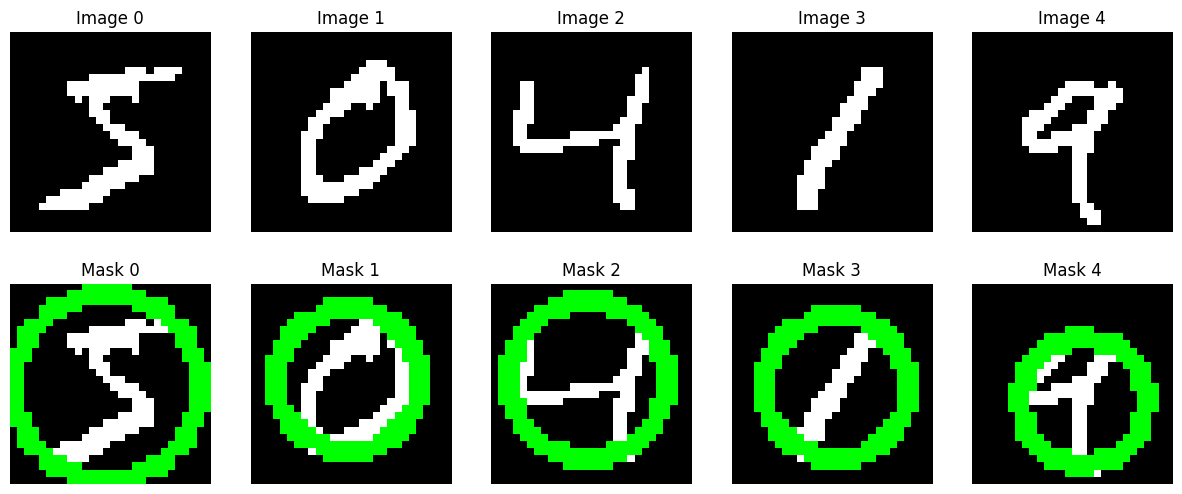

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.imshow(masks_train[i], cmap='gray')
        ax.set_title(f"Image {i}")
    else:
        ax.imshow(circle_train_images[i-5], cmap='gray')
        ax.set_title(f"Mask {i-5}")
    ax.axis('off')
plt.show()


Train images shape: (2000, 56, 56), dtype: uint8
Train masks shape: (2000, 56, 56), dtype: int64
Train masks one-hot shape: (2000, 11, 56, 56), dtype: float32
Test images shape: (100, 56, 56), dtype: uint8
Test masks shape: (100, 56, 56), dtype: int64
Test masks one-hot shape: (100, 11, 56, 56), dtype: float32


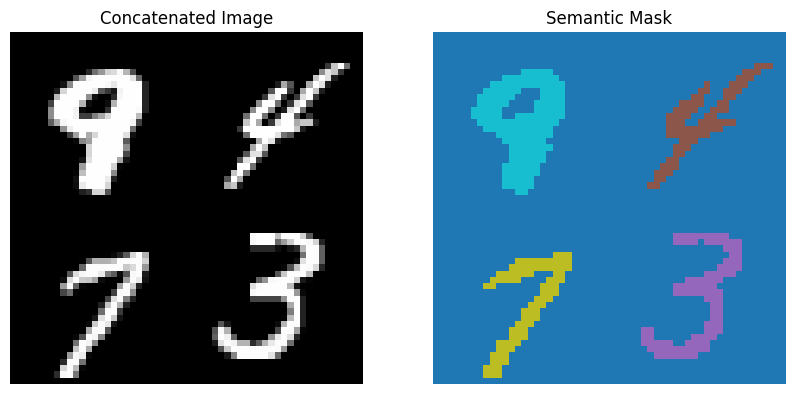

In [10]:
# Function to concatenate 4 images and masks
def create_concatenated_dataset(images, masks, labels, num_samples):
    """
    Create a dataset by concatenating 4 images/masks in a 2x2 grid.
    Args:
        images: (N, 28, 28), uint8
        masks: (N, 28, 28), float32 (0/1)
        labels: (N,), int64 (0-9)
        num_samples: Number of new samples to generate
    Returns:
        new_images: (num_samples, 56, 56), uint8
        new_masks: (num_samples, 56, 56), int64 (0-10, background=0)
        new_masks_onehot: (num_samples, 11, 56, 56), float32
    """
    new_images = []
    new_masks = []
    num_images = len(images)

    for _ in range(num_samples):
        # Randomly select 4 indices
        idx = np.random.choice(num_images, 4, replace=False)
        img1, img2, img3, img4 = images[idx]
        mask1, mask2, mask3, mask4 = masks[idx] /255
        label1, label2, label3, label4 = labels[idx]

        # Concatenate images (56x56)
        top = np.hstack([img1, img2])
        bottom = np.hstack([img3, img4])
        new_img = np.vstack([top, bottom])

        # Create semantic mask (0 for background, 1-10 for digits)
        new_mask = np.zeros((56, 56), dtype=np.int64)
        # Assign class labels (label + 1 to reserve 0 for background)
        new_mask[:28, :28] = mask1 * (label1 + 1)
        new_mask[:28, 28:] = mask2 * (label2 + 1)
        new_mask[28:, :28] = mask3 * (label3 + 1)
        new_mask[28:, 28:] = mask4 * (label4 + 1)

        new_images.append(new_img)
        new_masks.append(new_mask)

    new_images = np.array(new_images)
    new_masks = np.array(new_masks)

    # One-hot encode masks
    new_masks_onehot = np.zeros((num_samples, 11, 56, 56), dtype=np.float32)
    for i in range(num_samples):
        for c in range(11):
            new_masks_onehot[i, c] = (new_masks[i] == c).astype(np.float32)

    return new_images, new_masks, new_masks_onehot

# Generate datasets
num_train_samples = 2000  # Arbitrary, can match 60000 if needed
num_test_samples = 100    # Arbitrary, can match 10000
train_images_2x2, train_masks_2x2, train_masks_onehot = create_concatenated_dataset(
    images_train[:2000], masks_train[:2000], labels_train[:2000], num_train_samples
)
test_images_2x2, test_masks_2x2, test_masks_onehot = create_concatenated_dataset(
    images_test[:100], masks_test[:100], labels_test[:100], num_test_samples
)

# Save datasets (optional)
# np.save("./data/train_images_2x2.npy", train_images_2x2)
# np.save("./data/train_masks_onehot.npy", train_masks_onehot)
# np.save("./data/test_images_2x2.npy", test_images_2x2)
# np.save("./data/test_masks_onehot.npy", test_masks_onehot)

# Verify shapes
print(f"Train images shape: {train_images_2x2.shape}, dtype: {train_images_2x2.dtype}")
print(f"Train masks shape: {train_masks_2x2.shape}, dtype: {train_masks_2x2.dtype}")
print(f"Train masks one-hot shape: {train_masks_onehot.shape}, dtype: {train_masks_onehot.dtype}")
print(f"Test images shape: {test_images_2x2.shape}, dtype: {test_images_2x2.dtype}")
print(f"Test masks shape: {test_masks_2x2.shape}, dtype: {test_masks_2x2.dtype}")
print(f"Test masks one-hot shape: {test_masks_onehot.shape}, dtype: {test_masks_onehot.dtype}")

# Visualize a sample
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_images_2x2[0], cmap='gray')
axes[0].set_title("Concatenated Image")
axes[0].axis('off')

# Show the class mask (non-one-hot for visualization)
axes[1].imshow(train_masks_2x2[0], cmap='tab10')
axes[1].set_title("Semantic Mask")
axes[1].axis('off')
plt.show()

In [12]:
# Question - 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())  # Should return True if GPU is accessible

# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images.astype(np.float32) / 255.0
        self.masks = masks.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]).unsqueeze(0), torch.tensor(self.masks[idx]).unsqueeze(0)

# Model
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        self.enc1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec2 = nn.Conv2d(32, 1, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.relu(self.enc1(x))
        x2 = self.pool(self.relu(self.enc2(x1)))
        x = self.up(x2)
        x = self.relu(self.dec1(x))
        x = self.sigmoid(self.dec2(x))
        return x

# IoU
def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Data Loaders
train_dataset = SegmentationDataset(images_train, masks_train/255)
test_dataset = SegmentationDataset(images_test, masks_test/255)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SegmentationNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(10):
    model.train()
    running_loss = 0
    for images, masks in train_loader:
        images, masks = images, masks
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')



True
Epoch 1, Loss: 0.0442172921618133
Epoch 2, Loss: 0.02113412590776838
Epoch 3, Loss: 0.015607870643589098
Epoch 4, Loss: 0.01258044503033479
Epoch 5, Loss: 0.010824483576546442
Epoch 6, Loss: 0.009599760463183274
Epoch 7, Loss: 0.00862824470688428
Epoch 8, Loss: 0.007878279850593826
Epoch 9, Loss: 0.007247295206301471
Epoch 10, Loss: 0.006710819718338597


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [14]:
# Evaluation
model.eval()
total_iou = 0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images, masks
        outputs = model(images)
        total_iou += calculate_iou(outputs, masks).item()
print(f'Test IoU: {total_iou / len(test_loader)}')

Test IoU: 0.9835462338605504


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom Dataset
class CircleDataset(Dataset):
    def __init__(self, images, circles):
        self.images = images.astype(np.float32) / 255.0
        self.circles = circles.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]).unsqueeze(0), torch.tensor(self.circles[idx])

# Model
class CircleNet(nn.Module):
    def __init__(self):
        super(CircleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_class = nn.Linear(128, 10)
        self.fc_reg = nn.Linear(128, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        class_out = self.fc_class(x)
        reg_out = self.fc_reg(x)
        return class_out, reg_out

# Circle IoU
def circle_iou(pred, gt):
    x1, y1, r1 = pred
    x2, y2, r2 = gt
    d = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
    if d >= r1 + r2:
        return 0.0
    if d <= abs(r1 - r2):
        return 1.0 if r1 < r2 else (r1 / r2)**2
    # Approximate intersection
    a = r1**2 * np.arccos((d**2 + r1**2 - r2**2) / (2 * d * r1 + 1e-6))
    b = r2**2 * np.arccos((d**2 + r2**2 - r1**2) / (2 * d * r2 + 1e-6))
    c = 0.5 * ((r1 + r2 - d) * (d + r1 - r2) * (d + r2 - r1) * (d + r1 + r2))**0.5
    intersection = a + b - c
    union = np.pi * (r1**2 + r2**2) - intersection
    return intersection / (union + 1e-6)

# Data Loaders
train_dataset = CircleDataset(images_train, circle_train)
test_dataset = CircleDataset(images_test, circle_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CircleNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
class_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()

for epoch in range(10):
    model.train()
    running_loss = 0
    for images, circles in train_loader:
        images, circles = images.to(device), circles.to(device)
        labels = circles[:, 3].long()
        circle_params = circles[:, :3]
        optimizer.zero_grad()
        class_out, reg_out = model(images)
        class_loss = class_criterion(class_out, labels)
        reg_loss = reg_criterion(reg_out, circle_params)
        loss = class_loss + reg_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

# Evaluation
model.eval()
total_iou = 0
num_samples = 0
with torch.no_grad():
    for images, circles in test_loader:
        images, circles = images.to(device), circles.to(device)
        labels = circles[:, 3].long()
        class_out, reg_out = model(images)
        pred_labels = torch.argmax(class_out, dim=1)
        for i in range(len(pred_labels)):
            if pred_labels[i] == labels[i]:
                total_iou += circle_iou(reg_out[i].cpu().numpy(), circles[i, :3].cpu().numpy())
            num_samples += 1
print(f'Test IoU: {total_iou / num_samples}')

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset
class SemanticDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images.astype(np.float32) / 255.0  # Normalize images to [0, 1]
        self.masks = masks.astype(np.int64)              # Ensure masks are class indices

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)  # (1, 56, 56)
        mask = torch.tensor(self.masks[idx], dtype=torch.int64)                  # (56, 56)
        return image, mask

# Model
class SemanticNet(nn.Module):
    def __init__(self, num_classes=11):
        super(SemanticNet, self).__init__()
        self.enc1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec2 = nn.Conv2d(32, num_classes, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.enc1(x))
        x2 = self.pool(self.relu(self.enc2(x1)))
        x = self.up(x2)
        x = self.relu(self.dec1(x))
        x = self.dec2(x)  # (batch, num_classes, 56, 56)
        return x

# Dice Coefficient
def calculate_dice(pred, target):
    pred = torch.argmax(pred, dim=1)  # (batch, 56, 56)
    dice = 0
    for c in range(11):
        p = (pred == c).float()
        t = (target == c).float()
        intersection = (p * t).sum()
        dice += (2 * intersection + 1e-6) / (p.sum() + t.sum() + 1e-6)
    return dice / 11

# Data Loaders
# Assume train_images_2x2, train_masks_2x2, test_images_2x2, test_masks_2x2 from Q1(c)
train_dataset = SemanticDataset(train_images_2x2, train_masks_2x2)
test_dataset = SemanticDataset(test_images_2x2, test_masks_2x2)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SemanticNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    running_loss = 0
    for images, masks in train_loader:
        images, masks = images, masks
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

# Evaluation
model.eval()
total_dice = 0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images, masks
        outputs = model(images)
        total_dice += calculate_dice(outputs, masks).item()
print(f'Test Dice: {total_dice / len(test_loader)}')

Epoch 1, Loss: 0.5791095597743988
Epoch 2, Loss: 0.36311874651908876
Epoch 3, Loss: 0.34970972275733947
Epoch 4, Loss: 0.3405737617015839
Epoch 5, Loss: 0.3309257740974426
Epoch 6, Loss: 0.3234774625301361
Epoch 7, Loss: 0.3159491047859192
Epoch 8, Loss: 0.308372368812561
Epoch 9, Loss: 0.30144929718971253
Epoch 10, Loss: 0.29597625207901
Test Dice: 0.33139161126954214


In [ ]:
# video background subtraction

import cv2
import numpy as np

video = cv2.VideoCapture(r"C:\Users\vinay\OneDrive\Desktop\courses\Sem-4\EE655\q5_18a4ee81-96e1-4415-94a6-c8e9521bce78\q5\denis_walk.avi")
bg_image = cv2.imread(r"C:\Users\vinay\OneDrive\Desktop\courses\Sem-4\EE655\q5_18a4ee81-96e1-4415-94a6-c8e9521bce78\q5\bg.png")

frames = []

while True:
    ret, frame = video.read()

    if not ret:
        break
    # frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    frames.append(frame)


initialFrame = frames[0]

def averageFrame(frames):
    add_frame = np.zeros(np.shape(frames[0]))
    for i in range(len(frames)):
        add_frame = add_frame + frames[i]
    return ((add_frame)/len(frames))

avg_frame = np.array(averageFrame(frames),dtype=np.uint8)

for i in range(len(frames)):
    # frame difference
    # cv2.imshow("vid1",frames[i+1] - frames[i])

    # frame - avg. frame
    # print(avg_frame)
    abs_mat = abs(frames[i] - avg_frame)
    # Convert difference to grayscale
    gray = cv2.cvtColor(abs_mat, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding
    _, otsu_threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    new_vid_frame = np.zeros_like(frames[i])
    for j in range(frames[0].shape[0]):
        for k in range(frames[0].shape[1]):
            if otsu_threshold[j,k] == 255:
                new_vid_frame[j,k] = frames[i][j,k]
            else:
                new_vid_frame[j,k] = bg_image[j,k]

    cv2.imshow("video",new_vid_frame)

    # frame - initial frame
    # cv2.imshow("vid3", frames[i+1] - initialFrame)

    cv2.waitKey(40)

video.release()
cv2.destroyAllWindows()
